In [27]:
import openai
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

openai.api_key = os.environ['OPENAI_API_KEY']


In [25]:
def request_gpt(input_str) :

    chatgpt_sys_message = "You are a helpful assistant that performs time series predictions. The user will provide a sequence and you will predict the remaining sequence. The sequence is represented by decimal strings separated by commas."
    extra_input = "Please continue the following sequence without producing any additional text. Do not say anything like 'the next terms in the sequence are', just return the numbers. Sequence:\n"




    response = openai.ChatCompletion.create(
                model= "gpt-4-vision-preview",
                messages=[
                        {"role": "system", "content": chatgpt_sys_message},
                        {"role": "user", "content": extra_input + input_str}
                    ],
                temperature=1.0,
                n=1,
            )

    list_response = [choice.message.content for choice in response.choices]
    return list_response

In [30]:
def str_convert(data) :
    final_str = ""
    for elt in data :
        str_number = str(round(elt))
        final_str = final_str + str_number + ", "
    return final_str


def plot_preds_candles(df, train, test, pred, model_name, show_samples=False, save_index = 0):

    save_folder = "./plot/" + str(save_index)
    index = len(train)

    opens = pd.Series(df['open'].values, index=df['date'])
    truth = pd.Series(df['close'].values, index=df['date'])
    highs = pd.Series(df['high'].values, index=df['date'])
    lows = pd.Series(df['low'].values, index=df['date'])

    plt.figure(figsize=(8, 6), dpi=100)

    ## Draw candles
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')

    plt.bar(range(len(truth)), height, bottom=bottom, color=color, align='center')
    plt.vlines(range(len(highs)), ymin=lows, ymax=highs, color=color, linewidth=1)            

    plt.plot(range(index, index + len(pred)), pred, label=model_name, color='purple')
    
    index_to_display = range(0, len(truth), len(truth) // 6)
    display_date = truth.index[index_to_display]
    plt.xticks(index_to_display, display_date)

    # plt.xticks(range(len(truth)), truth.index)
    # plt.grid()

    plt.savefig(save_folder)
    plt.show()


Input str :  34152, 33893, 34081, 34526, 34476, 34641, 
GPT Answer :  ['34790, 34916, 35022']
[[34790, 34916, 35022, 35022, 35022, 35022, 35022]]


FileNotFoundError: [Errno 2] No such file or directory: './plot/0.png'

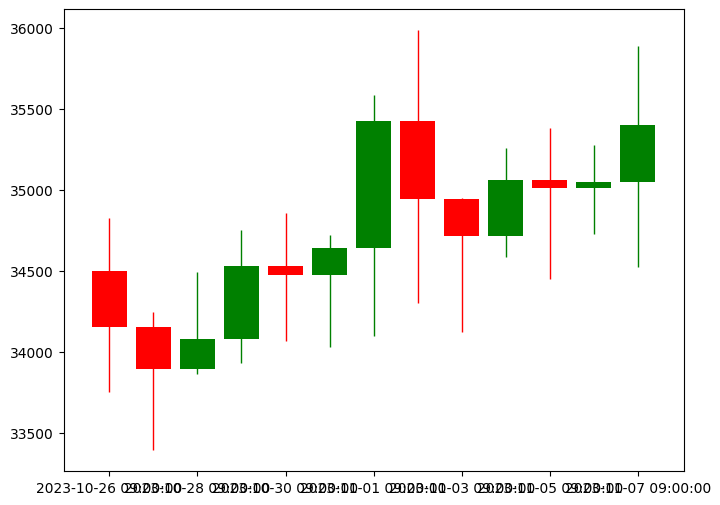

In [32]:
ending_predict_date = '2023-11-01'
ending_dates = ['2023-11-04', '2023-11-06', '2023-11-08']
index_save = 0


for input_length in [6, 12, 24, 48, 96, 192] :

    ending_predict_date_num = datetime.strptime(ending_predict_date, '%Y-%m-%d')
    new_date = ending_predict_date_num - timedelta(days=input_length)

    start_date = new_date.strftime('%Y-%m-%d')
    end_date = ending_dates[-1]

    with open(f"datasets/BTC_Daily_ohlc.csv") as f:
        df = pd.read_csv(f, usecols=[0, 4], parse_dates=[0])
        mask = (df["date"] >= start_date) & (df["date"] <= end_date)
        df = df.loc[mask]
        df['close'] = df['close'].astype(float)
        series = pd.Series(df['close'].values, index=df['date'])

        f.seek(0)
        df_raw = pd.read_csv(f, parse_dates=[0])
        df_raw = df_raw.loc[mask]

        splitpoint = input_length
        train = series.iloc[:splitpoint]
        test = series.iloc[splitpoint:]

    input_str = str_convert(train.values)


    print("Input str : ", input_str)
    list_response = request_gpt(input_str)
    print("GPT Answer : ", list_response)

    dic_int_list = []
    final_dic_int_list = []
    for elt in list_response :
        sub_chains = elt.split(',')
        int_list = [int(sub_chain.strip()) for sub_chain in sub_chains]

        dic_int_list.append(int_list)

    for elt in dic_int_list :
        if (len(elt) > 7) :
            new_elt = elt[:7]
        elif (len(elt) < 7) :
            last_numb = elt[-1]
            new_elt = elt
            while (len(new_elt) < 7) :
                new_elt.append(last_numb)
        final_dic_int_list.append(new_elt)

    print(final_dic_int_list)

    plot_preds_candles(df_raw, train, test, final_dic_int_list, "gpt-4-vision-preview", show_samples=False, save_index = 0)




[[34740, 34740, 34740, 34740, 34740, 34740, 34740], [34557, 34618, 34672, 34729, 34785, 34842, 34898], [34652, 34564, 34476, 34528, 34528, 34528, 34528], [34692, 34692, 34692, 34692, 34692, 34692, 34692], [34695, 34695, 34695, 34695, 34695, 34695, 34695], [34599, 34523, 34668, 34605, 34829, 34676, 34651], [34320, 34382, 34201, 34115, 33792, 33850, 33755], [34597, 34678, 34560, 34345, 34300, 34300, 34300], [34668, 35013, 34963, 35308, 35308, 35308, 35308], [34592, 34613, 34613, 34613, 34613, 34613, 34613]]
